# Two Candidate SED Model For Pulsars

There are two possible SED models(PLEC and PLEC1) for spectral energy distribution(SED) of pulsar. Despite of the unverified validity of the corresponding physical meaning of some parameters in PLEC, it can also have a convincing description of the observational data we have got so far. In this acticle, I select 117 pulsars SED data(0.1~100GeV) from [Fermi LAT Second Catalog of Gamma-ray Pulsars](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/2nd_PSR_catalog/) to fit both models with Markov chain Monte Carlo(MCMC), tring to compare these two models from a statistical perspective and even give some potential explanation about differences of fitting results.   
For SEDs of pulsar, The spectrum of each pulsar was modeled as a power law with an exponential cutoff,
\begin{equation}
    \frac{\text{d}N}{\text{d}E} = K \left( \frac{E}{E_0} \right)^{-\Gamma} \text{exp}\left( - \frac{E}{E_{\text{cut}}}\right)^b
\end{equation}
And the difference between PLEC and PLEC1 is that if $b$ is fixed to 1, in which PLEC1 indicates $b$ is a fixed parameter in this model, and in PLEC model, $b$ is a free parameter. 

# Fitting with MCMC

The modules I will use for fitting inculde:
1. `astropy` for reading fits file
1. `emcee` for running MCMC
1. `corner`&`matplotlib` for visualizing fitting result
1. `numpy` for array manipulation 

## PSRJ0007+7303

First I want to demonstrate the whole fitting process for [PSRJ0007+7303](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PSRJ0007%2B7303&submit=SIMBAD+search). And repeat this process to all 117 pulsars in this catalog.

### Read FITS File 

In [1]:
# Import modules
import numpy as np
from astropy.io import fits
import emcee
import corner 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

hdulist = fits.open("data/PSRJ0007+7303_2PC_data.fits") # Load fits data
pulsar_sed = hdulist[1].data # PULSAR_SED extension


### Quick Glance at PSRJ0007+7303

<ErrorbarContainer object of 3 artists>

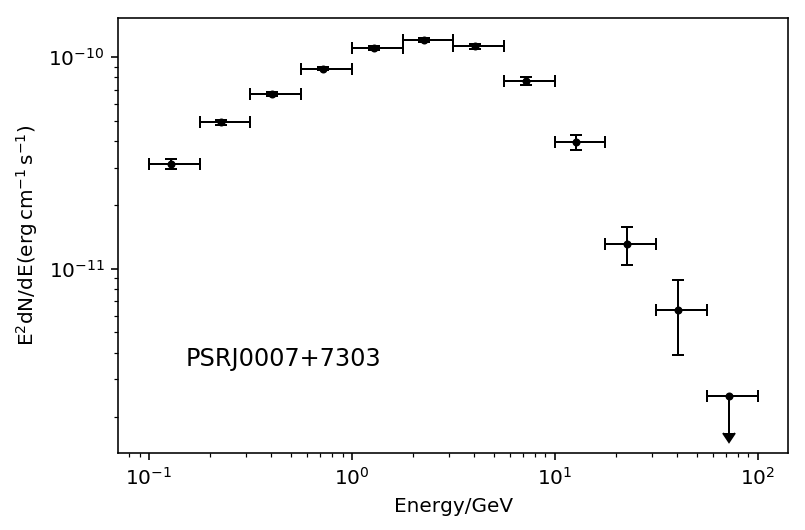

In [132]:
# Calculate energy interval uncerntainties
energy_lower_err = pulsar_sed["Center_Energy"] - pulsar_sed["Energy_Min"]
energy_upper_err = pulsar_sed["Energy_Max"] - pulsar_sed["Center_Energy"] 
energy_errs = np.vstack((energy_lower_err, energy_upper_err))
flux_density = pulsar_sed["EnergyFlux"] # Energy Unit: erg/ cm^2*s
flux_uplims = pulsar_sed["Unc_PhotonFlux"] == 0 # If unc equals zero, data is a upper limit
flux_unc = np.copy(pulsar_sed["Unc_EnergyFlux"]) # Unit: erg/ cm^2*s
flux_unc[flux_uplims] = flux_density[flux_uplims] / 3

fig, ax = plt.subplots()
# log-log axis scale
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy/GeV")
ax.set_ylabel("$\mathrm{E^2 dN/dE(erg\,cm^{-1}\,s^{-1})}$")
ax.text(0.1, 0.2, "PSRJ0007+7303", transform=ax.transAxes, fontsize=12)
ax.errorbar(pulsar_sed["Center_Energy"], flux_density,\
            yerr=flux_unc, xerr=energy_errs,\
            fmt='.k', capsize=3, uplims=flux_uplims, elinewidth=1)


### Run MCMC

PLEC1 model
\begin{equation}
        \frac{\text{d}N}{\text{d}E} = K \left( \frac{E}{E_0} \right)^{-\Gamma} \text{exp}\left( - \frac{E}{E_{\text{cut}}}\right)
\end{equation}
Parameter description:

1. $K$, prefactor
1. $\Gamma$, photon index at low energy
1. $E_0$, scale
1. $E_{\text{cut}}$, cutoff energy

Defined functions during MCMC  
\begin{align}
    \ln{(\text{prior})} &= 
    \begin{cases}
    
    \end{cases}\\
    
\end{align}

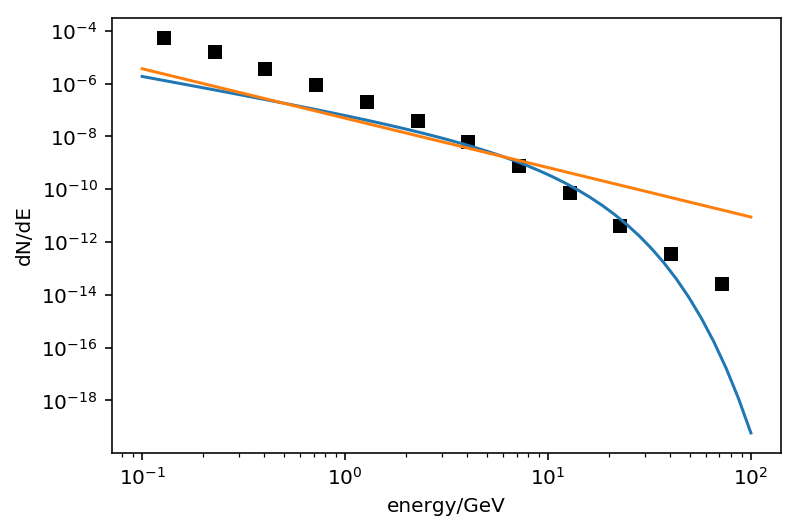

In [40]:
query = fits.open("data/2PC_catalog_v04.fits")
PSR_cat = query[2].data
test = PSR_cat[0]


def PLEC1(energy, prefactor, gamma, scale, cutoff):
    """
    Power law exponential cutoff with b fixed to 1 
    """
    return prefactor * (energy / scale)**(-gamma) * np.exp(- energy / cutoff)


def PLEC(energy, prefactor, gamma, scale, cutoff, beta):
    """
    Power law exponential cutoff with b fixed to 1 
    """
    return prefactor * (energy / scale)**(-gamma) * np.exp((- energy / cutoff)**beta)


def PL(energy, prefactor, scale, gamma):
    """
    Power law model
    """
    return prefactor * (energy / scale)**(-gamma)


def binit(lower, upper, integrand, n=100, **kwargs):
    """
    Integration over several bins in linspace
    lower: lower limit for each bin in linear space, MeV
    upper: upper limit for each bin in linear space, MeV
    integrand: function to be integrated
    n: number of samll rectanglar in each bin 
    """
    binned = np.zeros_like(lower)
    for i, (x0, x1) in enumerate(zip(lower, upper)):
        _dx = (x1 - x0) / (n - 1) # _dx is in linear space
        _x = np.linspace(x0, x1, n)  # _x is in linear space
        binned[i] = np.sum(integrand(_x, **kwargs)) * _dx # Euler method
    return binned
        
    
def chi_square(x, y, sigma, y_fit):
    """
    Calculate chi-square value of given parameters of a model
    
    x: observed x data
    y: observed y data
    sigma: uncertainties of observation 
    y_fit: optimized fitting result 
    
    """
    non_zeros = (sigma != 0)
    chi2 = np.sum((y[non_zeros] - y_fit[non_zeros])**2 / sigma[non_zeros]**2)
    return chi2

    
foo = np.logspace(-1, 2) # Energy for plotting 
plec1_theta = {"prefactor": test["PLEC1_Prefactor"], \
         "gamma": test["PLEC1_Photon_Index"], \
         "scale": test["PLEC1_Scale"], \
         "cutoff": test["PLEC1_Cutoff"]}
pl_theta = {"prefactor": test["PL_Prefactor"], \
         "gamma": test["PL_Photon_Index"], \
         "scale": test["PL_Scale"]}
bar = binit(1e3*energy_lower_err, 1e3*energy_upper_err, PL, n=100, **pl_theta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("energy/GeV")
plt.ylabel("dN/dE")
# plt.plot(pulsar_sed["Center_Energy"], bar, 'ro')
plt.plot(pulsar_sed["Center_Energy"], pulsar_sed["PhotonFlux"] / (energy_upper_err - energy_lower_err), 'ks')
plt.plot(foo, PLEC1(1e3 * foo, **plec1_theta) * 1e3)
plt.plot(foo, PL(1e3 * foo, **pl_theta) * 1e3)


(1e-12, 3.6280822920983116e-10)

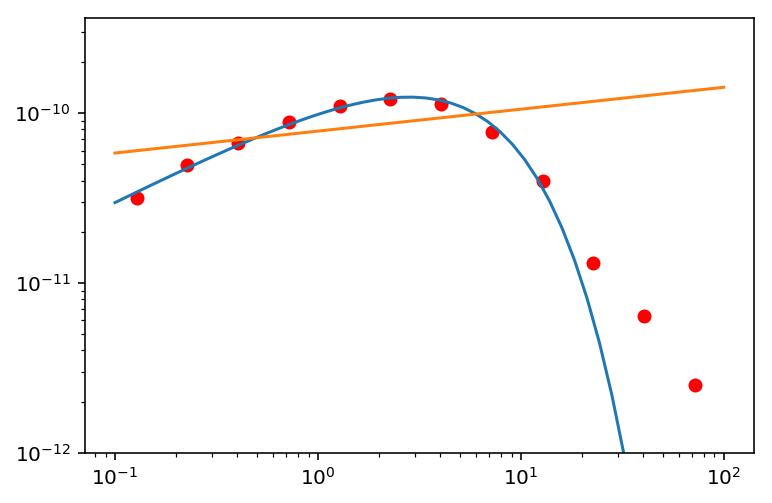

In [41]:
plt.xscale("log")
plt.yscale("log")
plt.plot(pulsar_sed["Center_Energy"], pulsar_sed["EnergyFlux"], 'ro')
plt.plot(foo, foo**2 * PLEC1(1e3 * foo, **plec1_theta) * 1e3 * 0.00160218)
plt.plot(foo, foo**2 * PL(1e3 * foo, **pl_theta) * 1e3 * 0.00160218)

plt.ylim(bottom=1e-12)


In [26]:
pl_chi = chi_square(pulsar_sed["Center_Energy"], pulsar_sed["PhotonFlux"], pulsar_sed["Unc_PhotonFlux"],\
          binit(1e3*energy_lower_err, 1e3*energy_upper_err, PL, n=100, **pl_theta))

plec_chi = chi_square(pulsar_sed["Center_Energy"], pulsar_sed["PhotonFlux"], pulsar_sed["Unc_PhotonFlux"],\
          binit(1e3*energy_lower_err, 1e3*energy_upper_err, PLEC1, n=100, **plec1_theta))

In [163]:
import emcee 
import corner


def PLEC1(energy, prefactor, gamma, cutoff, scale=727.4):
    """
    Power law exponential cutoff with b fixed to 1 
    
    energy: photon energy, MeV
    prefactor: ph cm^-2 s^-1 MeV^-1
    gamma: photon index, no unit
    cutoff: cutoff energy, MeV
    scale: scale energy(for Fermi LAT mission, fix scale to 1GeV)
    
    return E^2 * dN/dE, erg cm^-2 s^-1
    """
    return 1.60218e-6 * energy**2 * prefactor * (energy / scale)**(-gamma) * np.exp(- energy / cutoff)


def lnprior(theta):
    """
    ln(prior) function, flat parameters in a range.
    If parameters are all in valid range, return 0
    else, return np.inf 
    
    theta: 1d array, vector containing all parameters in given model
    
    Units: prefactor-----ph cm^-2 s^-1 MeV^-1
            gamma---------None
            cutoff--------MeV
            scale---------MeV
    
    return: scalar, 0 or np.inf 
    """
    prefactor, gamma, cutoff = theta 
    if 1e-10 < prefactor < 1e-9 and 1 < gamma < 3 \
    and 1e3 < cutoff < 1e5:
        return 0
    else:
        return np.inf
    
    
def lnlike(theta, x, y, yerr):
    """
    Calculate likelihood of obtaining experiment data given
    model parameters (in log form)
    
    theta: parameter array
    x: photon energy, MeV
    y: energy flux,  erg cm^-2 s^-1
    yerr: energy flux uncertainty, erg cm^-2 s^-1
    
    return: likelihood, scalar
    """
    # Zero error means upper limit of energy flux, ignore it for convience
    non_zeros = (yerr != 0)
    _y = y[non_zeros]
    _x = x[non_zeros]
    _yerr = yerr[non_zeros]
    prediction = PLEC1(_x, *theta)
    return -0.5 * np.sum((_y - prediction)**2 / _yerr**2)


def lnprob(theta, x, y, yerr):
    """
    Calculate posterior distribution function 
    
    theta: parameter array
    x: photon energy, MeV
    y: energy flux,  erg cm^-2 s^-1
    yerr: energy flux uncertainty, erg cm^-2 s^-1
    
    return: posterior, scalar
    """
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)
     

energys = pulsar_sed["Center_Energy"] * 1e3  # GeV to MeV
energy_flux = pulsar_sed["EnergyFlux"] 
energy_flux_err = pulsar_sed["Unc_EnergyFlux"]    

# Number of parameter and walker to be used in following MCMC run 
ndim, nwalkers = 3, 50
# Initial paramerter value
theta_fermi = np.array([1.182e-10, 1.397, 4662])  # Fitting result reported by Fermi team
theta0 = theta_fermi * 1e-2 * np.random.rand(nwalkers, ndim) + theta_fermi # Constrain initial position 
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(energys, energy_flux, energy_flux_err))
sampler.run_mcmc(theta0, 20000)
samples = sampler.flatchain # Convert samplers into a 2-D array


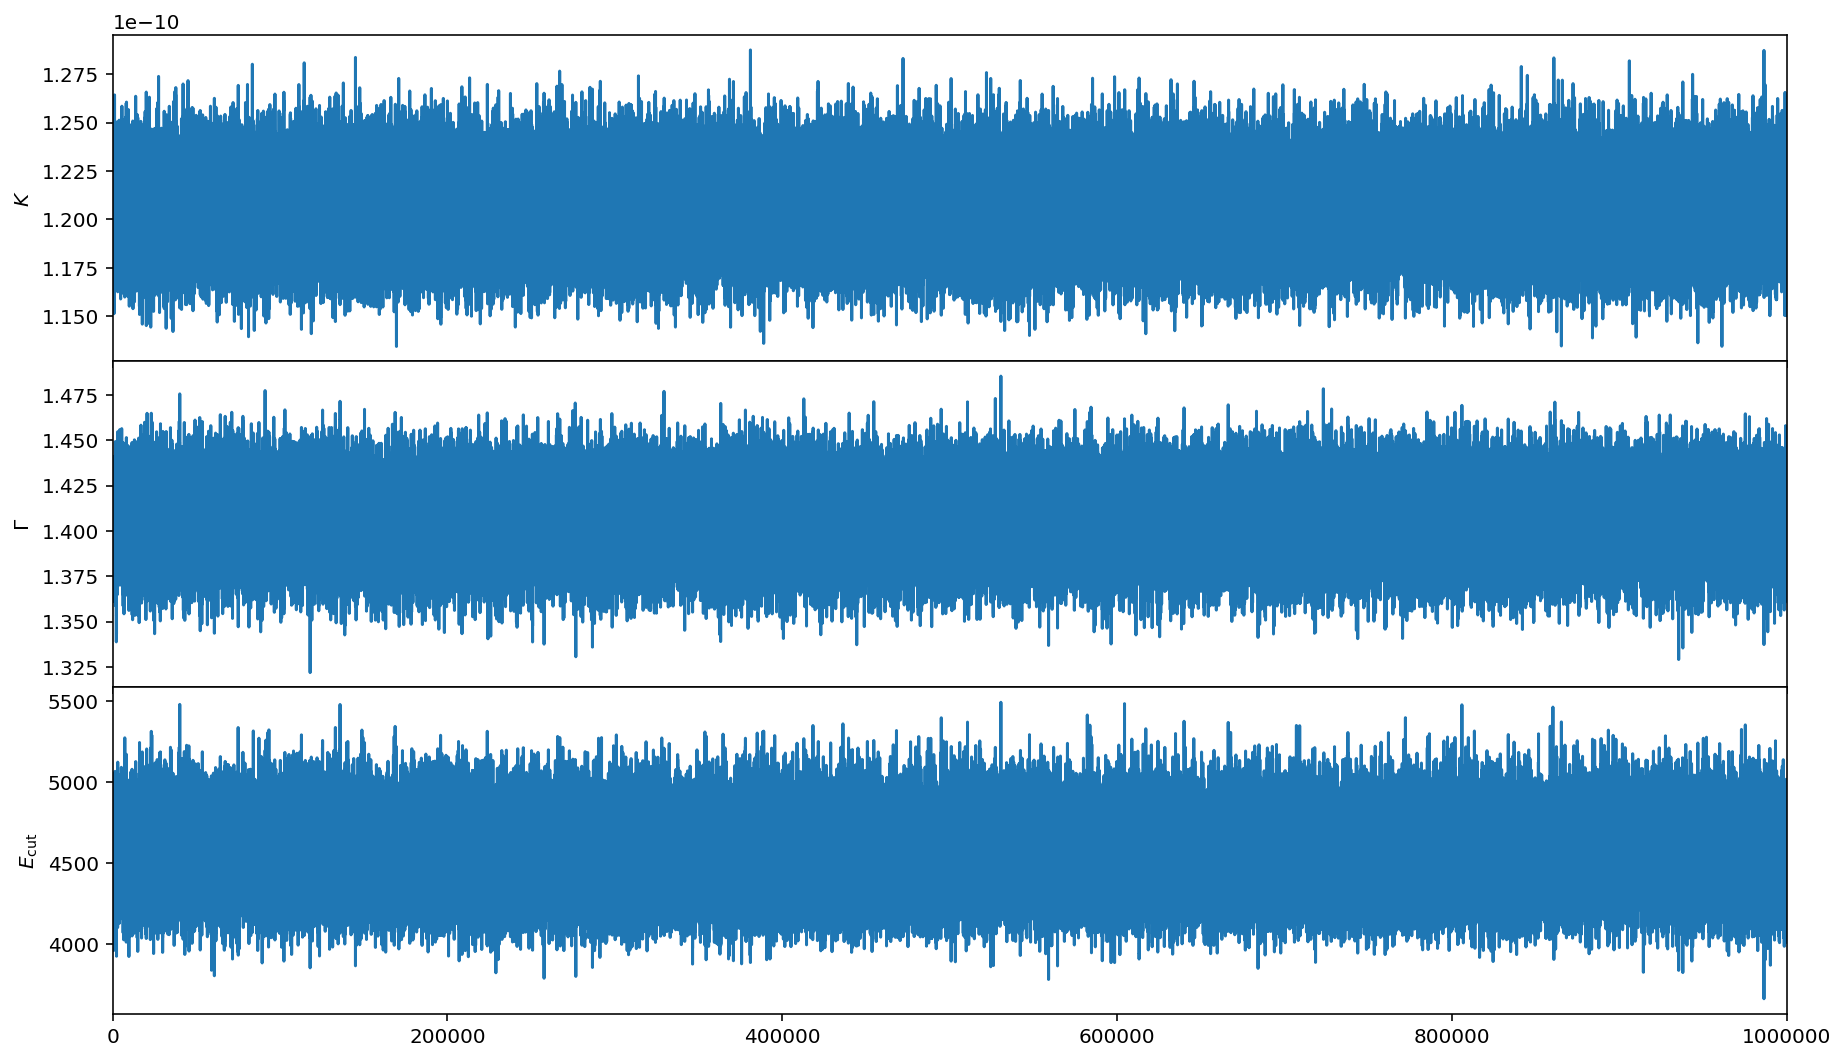

In [172]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 9), sharex=True)
ax[0].plot(samples[:,0])
ax[0].set_ylabel("$K$")
ax[1].plot(samples[:,1])
ax[1].set_ylabel("$\Gamma$")
ax[2].plot(samples[:,2])
ax[2].set_ylabel("$E_{\mathrm{cut}}$")
ax[2].set_xlim(0, nwalkers * 2e4)
fig.subplots_adjust(hspace=0)
# plt.savefig("SED_chain_plotting.png", dpi=500)

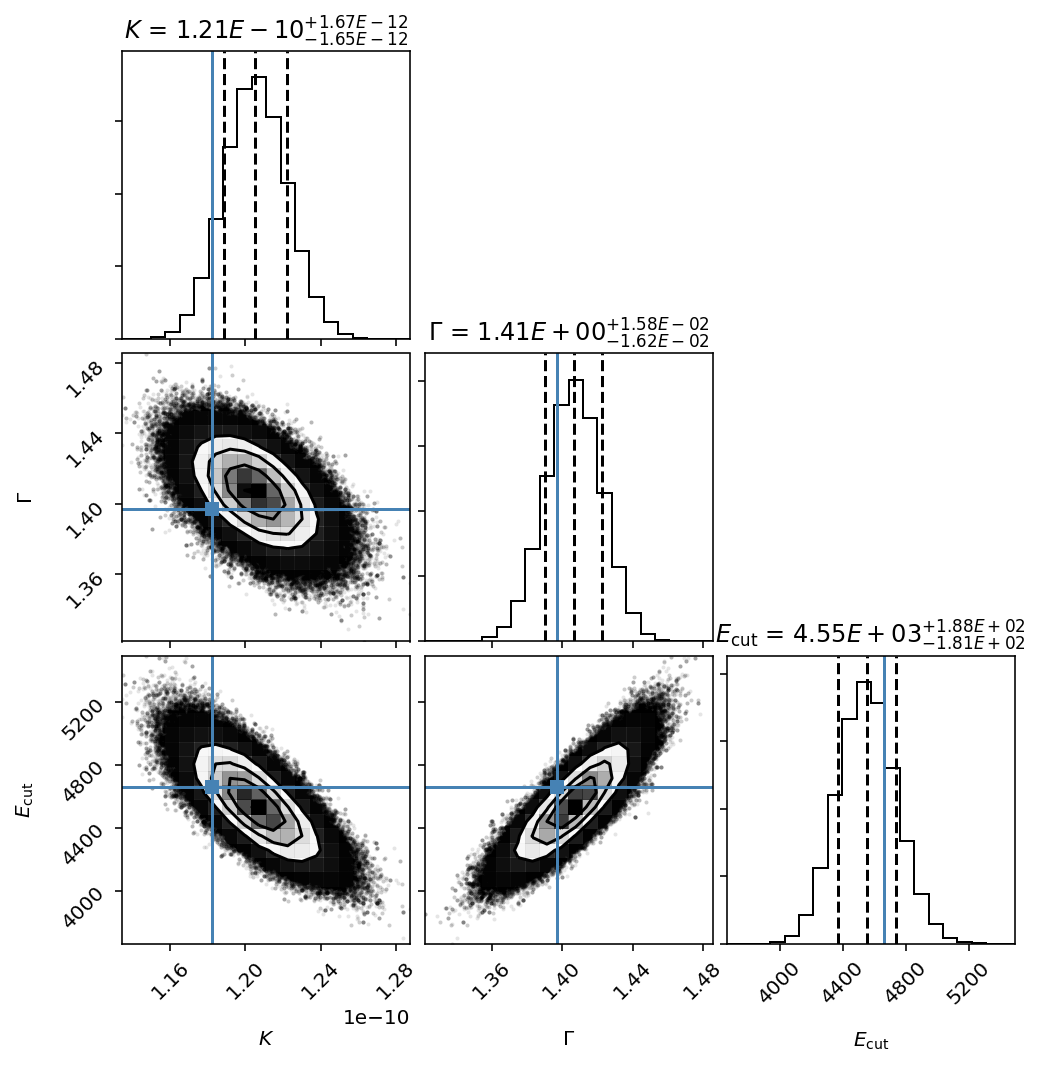

In [169]:
fig = corner.corner(samples[1000:], labels=["$K$", "$\Gamma$", "$E_{\mathrm{cut}}$", "Scale"],
                      truths=theta_fermi, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.2E')
# plt.savefig("SED_corner.pdf")

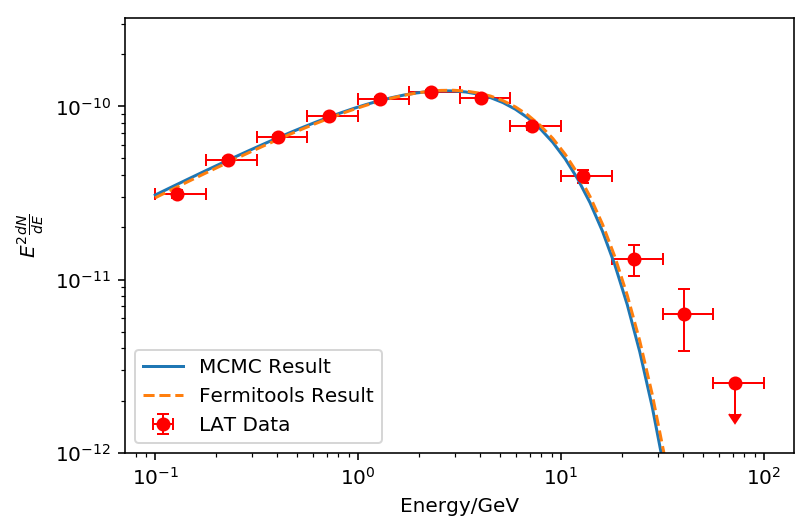

In [199]:
theta_max = samples[np.argmax(sampler.flatlnprobability)]
plt.xscale("log")
plt.yscale("log")
plt.errorbar(pulsar_sed["Center_Energy"], pulsar_sed["EnergyFlux"],\
             yerr=flux_unc * 1, xerr=energy_errs, fmt='ro',\
             capsize=3, uplims=flux_uplims, elinewidth=1, label='LAT Data')
plt.plot(foo, PLEC1(1e3 * foo, *theta_max), label='MCMC Result')
plt.plot(foo, PLEC1(1e3 * foo, **plec1_theta), ls='--', label="Fermitools Result")
plt.xlabel("Energy/GeV")
plt.ylabel(r"$E^2 \frac{dN}{dE}$")
plt.ylim(bottom=1e-12)
plt.legend()
plt.savefig("SED_result_comparison.pdf")

In [181]:
auto_time = emcee.autocorr.integrated_time(samples, axis=0)
auto_time_k = emcee.autocorr.function(samples[:,0])

C:\Users\hp\Anaconda3\lib\site-packages\emcee\autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
C:\Users\hp\Anaconda3\lib\site-packages\emcee\autocorr.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return acf / acf[m]
C:\Users\hp\Anaconda3\lib\site-packages\emcee\autocorr.py:105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array inde

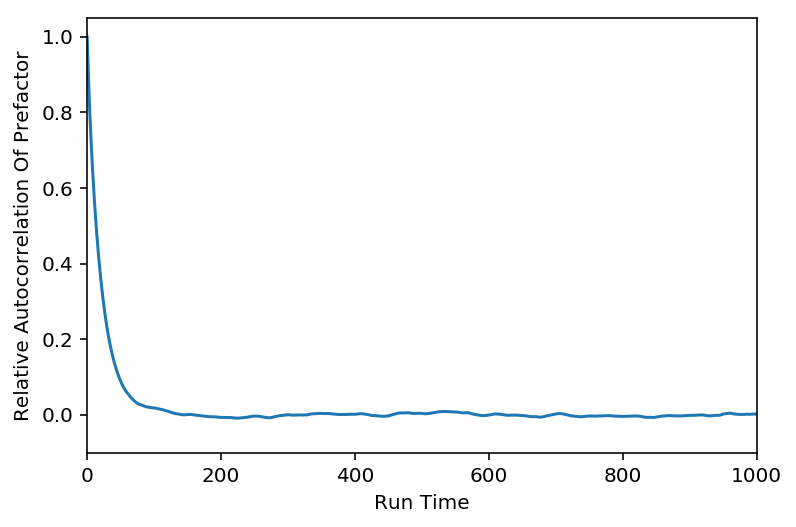

In [197]:
plt.plot(auto_time_k[:1000])
plt.xlabel("Run Time")
plt.ylabel("Relative Autocorrelation Of Prefactor")
plt.xlim(0,1000)
plt.ylim(-0.1,);
plt.savefig("Prefactor_autocorr.pdf")


# Result and Discussion